In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('ggplot')
import nltk

In [4]:
# Explore Data
df = pd.read_csv('data/AskReddit_posts_preprocessed.csv')
# Drop rows where 'comment_text' is NaN
df = df.dropna(subset=['comment_text'])


In [5]:
# Add an 'index' column
df.insert(0, 'index', range(len(df)))  # Adds a column named 'index' at the start


In [6]:
df.head()

,index,subreddit,post_id,post_title,comment_text,comment_score
0,0,AskReddit,1gkk9s3,2024 United States Elections Thread,much pollster predict iowa harris,60
1,1,AskReddit,1gkk9s3,2024 United States Elections Thread,devastating reminder social medium echo chambe...,180
2,2,AskReddit,1gkk9s3,2024 United States Elections Thread,often wonder campaign generally waste time we ...,33
3,3,AskReddit,1gkk9s3,2024 United States Elections Thread,matter win lose get drunk,56
4,4,AskReddit,1gkk9s3,2024 United States Elections Thread,day election night national holiday regret get...,44


In [7]:
print(df.shape)

(26160, 6)


### EDA: Exploratory Data Analysis

/var/folders/k8/490lh42x07b9r46c0sf7k9jh0000gn/T/ipykernel_3449/901532118.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['comment_score'], shade=True, color="skyblue")


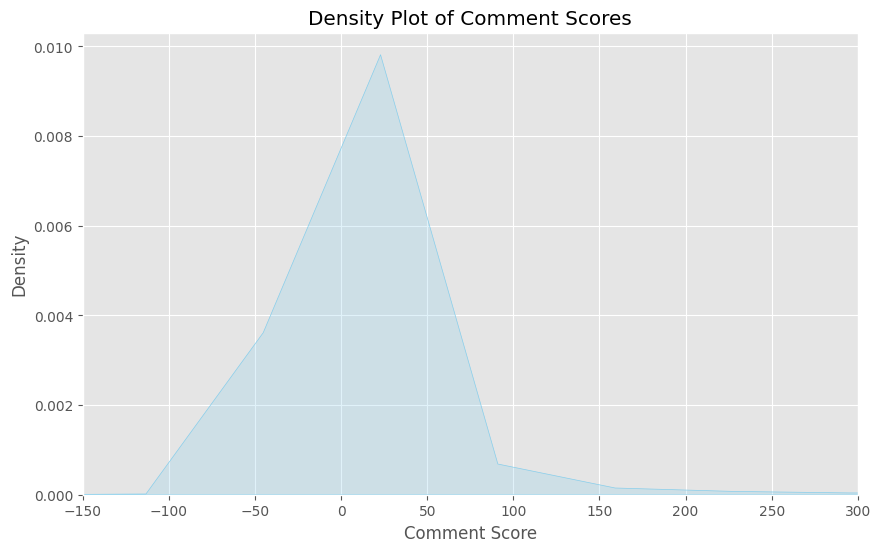

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['comment_score'], shade=True, color="skyblue")
plt.xlabel('Comment Score')
plt.ylabel('Density')
plt.title('Density Plot of Comment Scores')
plt.xlim(-150, 300)
plt.show()

### Using VADER
Though it doesn't count for relationships between words to give sentiment, but it provides a good start

In [9]:
example = df['comment_text'][100]
print(example)

uk hear trump basically orange bafoon convict rig last election sexual harassment stop immigration building wall bad america vote president


In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I feel so happy' )

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [12]:
sia.polarity_scores(example)

{'neg': 0.401, 'neu': 0.599, 'pos': 0.0, 'compound': -0.8658}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['comment_text']
    myid = row['index']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 26160/26160 [00:06<00:00, 4295.40it/s]


In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index()
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,index,neg,neu,pos,compound,subreddit,post_id,post_title,comment_text,comment_score
0,0,0.000,1.000,0.000,0.0000,AskReddit,1gkk9s3,2024 United States Elections Thread,much pollster predict iowa harris,60
1,1,0.323,0.677,0.000,-0.6486,AskReddit,1gkk9s3,2024 United States Elections Thread,devastating reminder social medium echo chambe...,180
2,2,0.310,0.519,0.171,-0.7506,AskReddit,1gkk9s3,2024 United States Elections Thread,often wonder campaign generally waste time we ...,33
3,3,0.464,0.091,0.445,-0.0516,AskReddit,1gkk9s3,2024 United States Elections Thread,matter win lose get drunk,56
4,4,0.181,0.645,0.174,-0.0258,AskReddit,1gkk9s3,2024 United States Elections Thread,day election night national holiday regret get...,44


In [16]:
vaders.iloc[10014]

index                                                        10014
neg                                                            0.0
neu                                                          0.839
pos                                                          0.161
compound                                                    0.3612
subreddit                                                AskReddit
post_id                                                    1glxhzw
post_title       What's a band you liked, but now think they ar...
comment_text     simple plan seem resonate like 9th grade sound...
comment_score                                                    5
Name: 10014, dtype: object

In [17]:
vaders['comment_text'][10014]

'simple plan seem resonate like 9th grade sound whiny can not bear listen anymore'

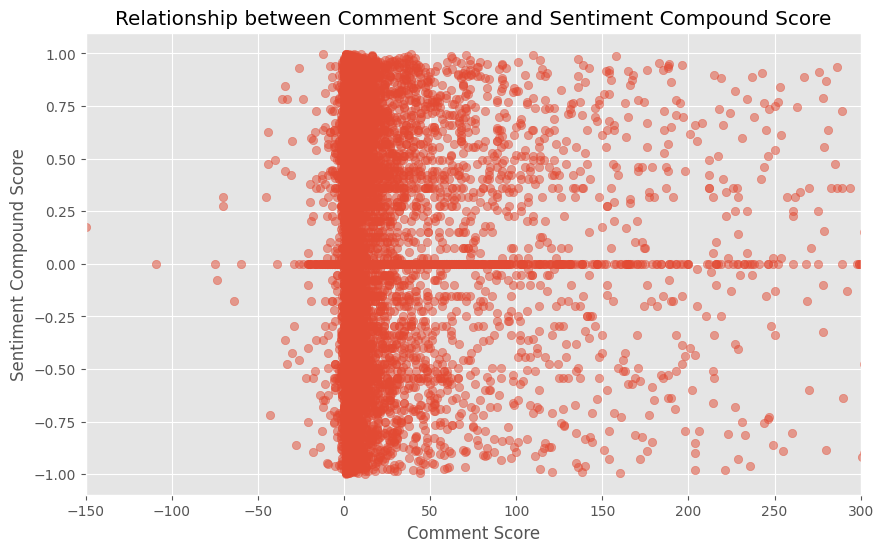

In [18]:
plt.figure(figsize=(10, 6))

# Plot the data
plt.scatter(vaders['comment_score'], vaders['compound'], alpha=0.5)

# Add labels and title
plt.xlabel('Comment Score')
plt.ylabel('Sentiment Compound Score')
plt.title('Relationship between Comment Score and Sentiment Compound Score')

# Show the plot
plt.xlim(-150, 300)
plt.show()

In [19]:
correlation = vaders['comment_score'].corr(vaders['compound'])
correlation


0.005095298462201764

I think this means that there's no relationship or what so ever between comment score and sentiment

In [20]:
vaders_2 = df.drop_duplicates(subset='post_title', keep='first')

In [21]:
# Run the polarity score on the post title of the entire dataset 
res = {}
for i, row in tqdm(vaders_2.iterrows(), total=len(vaders_2)):
    text = row['post_title']
    res[text] = sia.polarity_scores(text)

100%|██████████| 100/100 [00:00<00:00, 3181.89it/s]


In [22]:
vaders_2 = pd.DataFrame(res).T
vaders_2

,neg,neu,pos,compound
2024 United States Elections Thread,0.000,0.588,0.412,0.4215
Who is the ideal male role model for young men?,0.000,0.726,0.274,0.5267
What is the worst pain you’ve EVER felt?,0.552,0.448,0.000,-0.8126
"What’s the biggest fight you’ve gotten into, and what was it about?",0.191,0.809,0.000,-0.3818
What are you scared of as an adult that you weren’t scared of as a child?,0.309,0.691,0.000,-0.7003
...,...,...,...,...
What’s a superstition you absolutely believe?,0.000,1.000,0.000,0.0000
What are the advantages of being good at swearing and cursing?,0.130,0.519,0.351,0.5267
What artist or band do you dislike despite their popularity?,0.392,0.608,0.000,-0.6315
What are your pets currently doing?,0.000,1.000,0.000,0.0000


In [23]:
vaders

,index,neg,neu,pos,compound,subreddit,post_id,post_title,comment_text,comment_score
0,0,0.000,1.000,0.000,0.0000,AskReddit,1gkk9s3,2024 United States Elections Thread,much pollster predict iowa harris,60
1,1,0.323,0.677,0.000,-0.6486,AskReddit,1gkk9s3,2024 United States Elections Thread,devastating reminder social medium echo chambe...,180
2,2,0.310,0.519,0.171,-0.7506,AskReddit,1gkk9s3,2024 United States Elections Thread,often wonder campaign generally waste time we ...,33
3,3,0.464,0.091,0.445,-0.0516,AskReddit,1gkk9s3,2024 United States Elections Thread,matter win lose get drunk,56
4,4,0.181,0.645,0.174,-0.0258,AskReddit,1gkk9s3,2024 United States Elections Thread,day election night national holiday regret get...,44
...,...,...,...,...,...,...,...,...,...,...
26155,26155,0.286,0.714,0.000,-0.3400,AskReddit,1gmexng,What is the most awkward thing that ever happe...,accidentally wave back someone wave happen time,1
26156,26156,0.000,1.000,0.000,0.0000,AskReddit,1gmexng,What is the most awkward thing that ever happe...,unintentionally call date exs name first date ...,1
26157,26157,0.000,0.635,0.365,0.8481,AskReddit,1gmexng,What is the most awkward thing that ever happe...,social event think see someone know walk right...,1
26158,26158,0.049,0.513,0.438,0.9371,AskReddit,1gmexng,What is the most awkward thing that ever happe...,oh story sure start new job try make great imp...,1


In [24]:
vaders_2 = vaders_2.reset_index().rename(columns={'index': 'post_title', 'neg': 'neg_title', 'neu': 'neu_title', 'pos': 'pos_title', 'compound' : 'compound_title'})
vaders_2 = vaders_2.merge(vaders,how='right', on='post_title')
vaders_2

,post_title,neg_title,neu_title,pos_title,compound_title,index,neg,neu,pos,compound,subreddit,post_id,comment_text,comment_score
0,2024 United States Elections Thread,0.000,0.588,0.412,0.4215,0,0.000,1.000,0.000,0.0000,AskReddit,1gkk9s3,much pollster predict iowa harris,60
1,2024 United States Elections Thread,0.000,0.588,0.412,0.4215,1,0.323,0.677,0.000,-0.6486,AskReddit,1gkk9s3,devastating reminder social medium echo chambe...,180
2,2024 United States Elections Thread,0.000,0.588,0.412,0.4215,2,0.310,0.519,0.171,-0.7506,AskReddit,1gkk9s3,often wonder campaign generally waste time we ...,33
3,2024 United States Elections Thread,0.000,0.588,0.412,0.4215,3,0.464,0.091,0.445,-0.0516,AskReddit,1gkk9s3,matter win lose get drunk,56
4,2024 United States Elections Thread,0.000,0.588,0.412,0.4215,4,0.181,0.645,0.174,-0.0258,AskReddit,1gkk9s3,day election night national holiday regret get...,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26155,What is the most awkward thing that ever happe...,0.159,0.841,0.000,-0.2247,26155,0.286,0.714,0.000,-0.3400,AskReddit,1gmexng,accidentally wave back someone wave happen time,1
26156,What is the most awkward thing that ever happe...,0.159,0.841,0.000,-0.2247,26156,0.000,1.000,0.000,0.0000,AskReddit,1gmexng,unintentionally call date exs name first date ...,1
26157,What is the most awkward thing that ever happe...,0.159,0.841,0.000,-0.2247,26157,0.000,0.635,0.365,0.8481,AskReddit,1gmexng,social event think see someone know walk right...,1
26158,What is the most awkward thing that ever happe...,0.159,0.841,0.000,-0.2247,26158,0.049,0.513,0.438,0.9371,AskReddit,1gmexng,oh story sure start new job try make great imp...,1


In [25]:
# Calculate the correlation between the title sentiment and the post sentiment
correlation = vaders_2['compound'].corr(vaders_2['compound_title'])
correlation


0.19690558880009618

# there's a very weak relationship between title sentiment and comment sentiment

## Roberta Pretrained Model
- Use a model trained on a large corpus of data.
- Transformer model accounts for the words but also the context related to other words

In [26]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [27]:
import torch
print(torch.__version__)


2.5.1


In [28]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [29]:
# VADER results on example
print(example)
sia.polarity_scores(example)

uk hear trump basically orange bafoon convict rig last election sexual harassment stop immigration building wall bad america vote president


{'neg': 0.401, 'neu': 0.599, 'pos': 0.0, 'compound': -0.8658}

text must be Encoded and then embed that to the model to be understood

In [30]:
# Run Roberta Model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [31]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['comment_text']
        myid = row['index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  3%|▎         | 658/26160 [01:10<1:09:10,  6.14it/s]

Broke for id 656


  4%|▍         | 1053/26160 [01:50<35:34, 11.76it/s] 

Broke for id 1050


  5%|▌         | 1314/26160 [02:14<32:17, 12.82it/s]

Broke for id 1312


  5%|▌         | 1372/26160 [02:20<34:14, 12.06it/s]

Broke for id 1369


 47%|████▋     | 12183/26160 [18:07<19:40, 11.84it/s] 

Broke for id 12180


 81%|████████  | 21167/26160 [31:39<06:27, 12.89it/s]

Broke for id 21164


100%|██████████| 26160/26160 [39:24<00:00, 11.07it/s]


In [32]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index()
results_df = results_df.merge(df, how='left')

In [33]:
results_df.head()

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,subreddit,post_id,post_title,comment_text,comment_score
0,0,0.000,1.000,0.000,0.0000,0.074472,0.887767,0.037761,AskReddit,1gkk9s3,2024 United States Elections Thread,much pollster predict iowa harris,60
1,1,0.323,0.677,0.000,-0.6486,0.827450,0.164512,0.008039,AskReddit,1gkk9s3,2024 United States Elections Thread,devastating reminder social medium echo chambe...,180
2,2,0.310,0.519,0.171,-0.7506,0.757083,0.228403,0.014514,AskReddit,1gkk9s3,2024 United States Elections Thread,often wonder campaign generally waste time we ...,33
3,3,0.464,0.091,0.445,-0.0516,0.433912,0.475297,0.090791,AskReddit,1gkk9s3,2024 United States Elections Thread,matter win lose get drunk,56
4,4,0.181,0.645,0.174,-0.0258,0.700795,0.266801,0.032404,AskReddit,1gkk9s3,2024 United States Elections Thread,day election night national holiday regret get...,44


## Compare Scores between models

In [3]:
results_df.columns

NameError: name 'results_df' is not defined

In [2]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'], palette='tab10')

NameError: name 'sns' is not defined